In [1]:
from tabulate import tabulate
from scipy.interpolate import interp1d
import numpy as np
import math
from MAPScorer import MAPScorer
from scipy import interp
from mySVMbigramsFold0 import MySVM
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, precision_recall_fscore_support, f1_score, accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
svm = MySVM()
svm.loadData()
svm.loadModels()

load models


In [3]:
tasks = ['sede12']
yp = {}
ycn = {}
yc = {}
ytn = {}
yt = {}
for task in tasks:
    print(task)
    yp[task] = svm.model[task].decision_function(svm.XTest)
    yt[task] = svm.yTest[task]    
    ytn[task] = svm.lb[task].inverse_transform(yt[task])
    yc[task] = np.zeros(yt[task].shape, np.int)
    for i,p in enumerate(yp[task]):
        yc[task][i][np.argmax(p)] = 1
    ycn[task] = svm.lb[task].inverse_transform(yc[task])

sede12


In [4]:
print(svm.XTest.shape)
print(len(svm.yTest['sede12']))

(18813, 109398)
18813


In [5]:
table = [["task", "average", "meanAvgPrec", "accuracy", "kappa", "precision", "recall", "f1score"]]
na = 'N/A'
metrics = {}
for task in tasks:
    table.append([" ", " ", " ", " ", " ", " ", " "])
    metrics[task] = {}
    metrics[task][na] = {}
    metrics[task][na]['meanAvgPrec'] = MAPScorer().samplesScore(yt[task], yp[task])
    metrics[task][na]['accuracy'] = accuracy_score(yt[task], yc[task])
    metrics[task][na]['kappa'] = cohen_kappa_score(ytn[task], ycn[task])
    table.append([task, na, metrics[task][na]['meanAvgPrec'], metrics[task][na]['accuracy'], metrics[task][na]['kappa'], na, na, na])
    for avg in ['micro', 'macro', 'weighted']:
        metrics[task][avg] = {}
        metrics[task][avg]['precision'], metrics[task][avg]['recall'], metrics[task][avg]['f1score'], metrics[task][avg]['support'] = precision_recall_fscore_support(yt[task], yc[task], average=avg)
        table.append([task, avg, na, na, na, metrics[task][avg]['precision'], metrics[task][avg]['recall'], metrics[task][avg]['f1score']])
print(tabulate(table))
        

/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


------  --------  ------------------  ------------------  ------------------  -------------------  -------------------  -------------------
task    average   meanAvgPrec         accuracy            kappa               precision            recall               f1score

sede12  N/A       0.6386965079370212  0.6060702705575931  0.5862972114422745  N/A                  N/A                  N/A
sede12  micro     N/A                 N/A                 N/A                 0.6060702705575931   0.6060702705575931   0.6060702705575931
sede12  macro     N/A                 N/A                 N/A                 0.26156389221952764  0.13854005182798199  0.16465102210944985
sede12  weighted  N/A                 N/A                 N/A                 0.7789622009075887   0.6060702705575931   0.6586318618054069
------  --------  ------------------  ------------------  ------------------  -------------------  -------------------  -------------------


In [6]:
def _calculateMicroMacroCurve(curveFunction, yt, yp):
        n_classes = yt.shape[1]
        abscissa = dict()
        ordinate = dict()
        area = dict()
        for i in range(n_classes):
            abscissa[i], ordinate[i] = curveFunction(yt[:, i], yp[:, i])
            area[i] = auc(abscissa[i], ordinate[i])
        abscissa["micro"], ordinate["micro"] = curveFunction(yt.ravel(), yp.ravel())
        area["micro"] = auc(abscissa["micro"], ordinate["micro"])
        # aggregate all
        all_rec = list(filter(lambda x: not math.isnan(x), np.unique(np.concatenate([abscissa[i] for i in range(n_classes)]))))

        # interpolate all prec/rec curves at this points
        mean_ordinate = np.zeros_like(all_rec)
        representedClasses = 0
        unrepresentedClasses = 0
        for i in range(n_classes):
            interp = interp1d(abscissa[i], ordinate[i])
            curr_ordinate = interp(all_rec)
            if not np.any([math.isnan(x) for x in abscissa[i]]) and not np.any([math.isnan(x) for x in ordinate[i]]):
                mean_ordinate += curr_ordinate
                representedClasses += 1
            else:
                unrepresentedClasses += 1

        # average it and compute AUC
        mean_ordinate /= representedClasses

        abscissa["macro"] = all_rec
        ordinate["macro"] = mean_ordinate
        area["macro"] = auc(abscissa["macro"], ordinate["macro"])

        return (abscissa, ordinate, area)

In [7]:
rec = {}
pre = {}
pr_auc = {}
fpr = {}
tpr = {}
roc_auc = {}
for task in tasks:
    rec[task], pre[task], pr_auc[task] = _calculateMicroMacroCurve(lambda y,s: (lambda t: (t[1],t[0]))(precision_recall_curve(y,s)), yt[task], yp[task])
    fpr[task], tpr[task], roc_auc[task] = _calculateMicroMacroCurve(lambda y,s: (lambda t: (t[0],t[1]))(roc_curve(y,s)), yt[task], yp[task])

/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


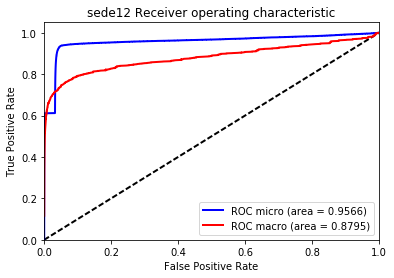

In [8]:
for task in tasks:
    fig = plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(task+' Receiver operating characteristic')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    #for c in range(n_classes):
    #    plt.plot(fpr[c], tpr[c], lw=1, label='ROC curve {} (area = {:0.2f})'.format(c, roc_auc[2]))
    plt.plot(fpr[task]['micro'], tpr[task]['micro'], color='blue', lw=2, label='ROC micro (area = %0.4f)' % roc_auc[task]['micro'])
    plt.plot(fpr[task]['macro'], tpr[task]['macro'], color='red', lw=2, label='ROC macro (area = %0.4f)' % roc_auc[task]['macro'])
    plt.legend(loc="lower right")
    
    plt.show()

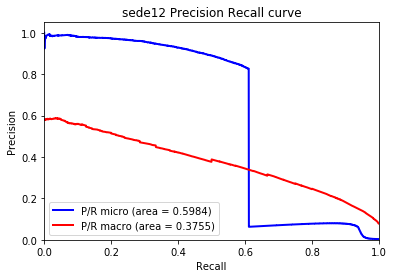

In [9]:
for task in tasks:
    fig = plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
 
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(task+' Precision Recall curve')
    #for c in range(n_classes):
    #    plt.plot(fpr[c], tpr[c], lw=1, label='ROC curve {} (area = {:0.2f})'.format(c, roc_auc[2]))
    plt.plot(rec[task]['micro'], pre[task]['micro'], color='blue', lw=2, label='P/R micro (area = %0.4f)' % pr_auc[task]['micro'])
    plt.plot(rec[task]['macro'], pre[task]['macro'], color='red', lw=2, label='P/R macro (area = %0.4f)' % pr_auc[task]['macro'])
    plt.legend(loc="lower left")
    
    plt.show()